<a href="https://colab.research.google.com/github/fMurugi/complete-neural-network-course/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets,models,transforms
import os
import numpy as np

In [3]:
data_transforms ={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip -d data/
!rm hymenoptera_data.zip

--2025-10-24 11:06:55--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.60.77, 108.156.60.94, 108.156.60.60, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.60.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   278MB/s    in 0.2s    

2025-10-24 11:06:55 (278 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [5]:
#load images and labels
data_dir = 'data/hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size = 4,shuffle=True)for x in ['train','val']}
#create a dict that contains the size of each dataset
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(f"train dataset {dataset_sizes['train']}")
print(f"val dataset {dataset_sizes['val']}")


train dataset 244
val dataset 153


In [6]:
model_conv = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 98.8MB/s]


In [7]:
#freeze all the layers in the network
for param in model_conv.parameters():
    param.requires_grad = False


In [8]:
#get the input of the last layer
num_ftrs = model_conv.fc.in_features
#reconstruct the last layer
model_conv.fc = nn.Linear(num_ftrs,2)


In [9]:
if torch.cuda.is_available():
  model_conv = model_conv.cuda()

In [10]:
# dealing with cross entropy since we have two classes ,we get softmax in this case
criterion = nn.CrossEntropyLoss()
#we are using parameters of last fully connected layer
optimizer = optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)


In [11]:
num_epochs =30
for epoch in range(num_epochs):
  exp_lr_scheduler.step()
  correct = 0
  for images,labels in dataloaders['train']:
      images = Variable(images)
      labels = Variable(labels)
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      optimizer.zero_grad()
      outputs = model_conv(images)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      _,pred = torch.max(outputs.data,1)
      correct += torch.sum(pred == labels.data)
  train_acc = 100 *correct /dataset_sizes['train']
  print(f"epoch {epoch} train acc {train_acc}")

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 0 train acc 72.13114166259766
epoch 1 train acc 79.91802978515625
epoch 2 train acc 75.40982818603516
epoch 3 train acc 73.36064910888672
epoch 4 train acc 77.45901489257812
epoch 5 train acc 76.22950744628906
epoch 6 train acc 84.01638793945312
epoch 7 train acc 86.06556701660156
epoch 8 train acc 84.01638793945312
epoch 9 train acc 79.91802978515625
epoch 10 train acc 87.70491027832031
epoch 11 train acc 80.73770141601562
epoch 12 train acc 84.01638793945312
epoch 13 train acc 87.70491027832031
epoch 14 train acc 79.50819396972656
epoch 15 train acc 84.42622375488281
epoch 16 train acc 81.96720886230469
epoch 17 train acc 81.557373046875
epoch 18 train acc 89.34425354003906
epoch 19 train acc 86.88523864746094
epoch 20 train acc 86.06556701660156
epoch 21 train acc 84.01638793945312
epoch 22 train acc 89.34425354003906
epoch 23 train acc 82.78688049316406
epoch 24 train acc 87.29507446289062
epoch 25 train acc 86.47540283203125
epoch 26 train acc 85.24589538574219
epoch 27 trai

In [12]:
# test the model
model_conv.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for (images,labels) in dataloaders['val']:
    images= Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = model_conv(images)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += torch.sum(pred == labels.data).sum().item()
  print(f'Test accuracy {100*correct/total:.3f}')

Test accuracy 94.118


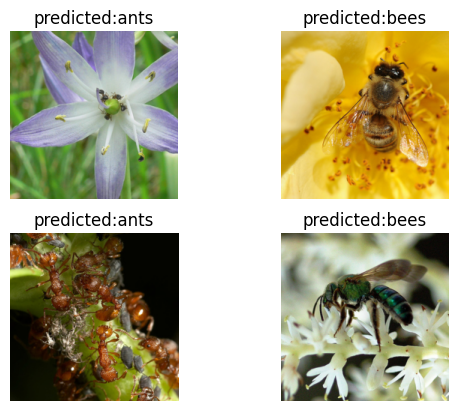

In [21]:
#visualize some prediction
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index =0
with torch.no_grad():
  for (images,labels) in dataloaders['val']:
    if shown_batch == 1:
      break
    shown_batch+=1
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = model_conv(images)
    _,preds = torch.max(outputs,1)

    for i in range(4):
      index+=1
      ax  = plt.subplot(2,2,index)
      ax.axis('off')
      ax.set_title(f"predicted:{class_names[preds[i]]}")
      input_img = images.cpu().data[i].numpy()
      input_img = input_img.transpose((1,2,0))
      mean = np.array([0.485,0.456,0.406])
      std = np.array([0.229,0.224,0.225])
      input_img = std * input_img + mean #denormalization
      # input_img = np.clip(input_img,0,1)
      plt.imshow(input_img)
    plt.show()

